In [1]:
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
import torch
from torch.utils.data import random_split,DataLoader,TensorDataset
from PIL import Image
import torchvision
import os
import random

### Actividad de CNN

In [2]:
from torchvision import transforms,datasets

transform = transforms.Compose([transforms.Resize((224,224)),transforms.ToTensor()])

path = "pieces"
dataset = datasets.ImageFolder(path,transform=transform)

train_set,val_set,test_set = random_split(dataset,[400-1,125,126],generator=torch.Generator().manual_seed(619))

train_loader = DataLoader(train_set,batch_size=32,shuffle=True)
val_loader = DataLoader(val_set,batch_size=32,shuffle=True)
test_loader = DataLoader(test_set,batch_size=32,shuffle=True)   

En el siguiente bloque explore la data, con el fin de responder a estas preguntas.  
- ¿De que se trata el dataset?
- ¿Cuales son las clases de salida?
- ¿Cuantas imagenes hay por clase?
- ¿Cual es el tamaño de las imagenes?
- ¿Cuantas imagenes hay en total?
- Grafique algunas imagenes de cada clase
- etc.

In [3]:
#Para mostrar X imagenes aleatorias
X = 5
indices = random.sample(range(len(dataset)), X)
print(indices)

[113, 179, 288, 339, 55]


Clases: ['bishop', 'knight', 'pawn', 'queen', 'rook']
{'bishop': 0, 'knight': 1, 'pawn': 2, 'queen': 3, 'rook': 4}

Cantidad de imagenes: 650
Cantidad de alfiles : 141
Cantidad de Caballos : 174
Cantidad de Peones : 81
Cantidad de Reinas : 115
Cantidad de Torre : 139

Ya que se redimensionaron las imagenes a 224x244 en transform, todas las imagenes tendrán ese tamaño
torch.Size([3, 224, 224])

Total de imágenes: 650


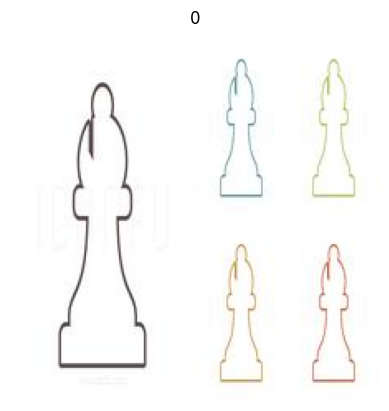

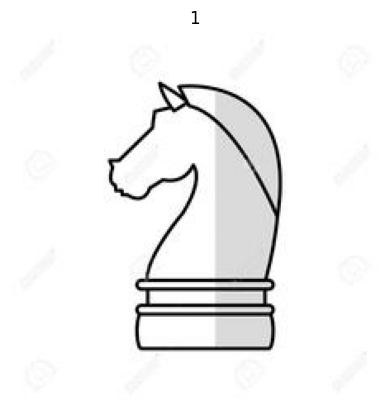

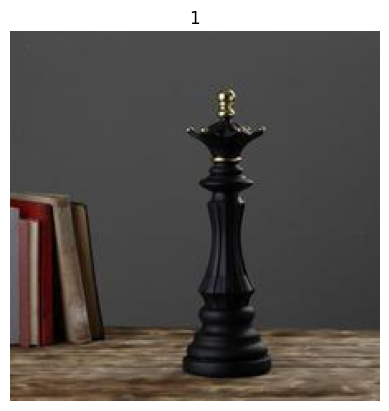

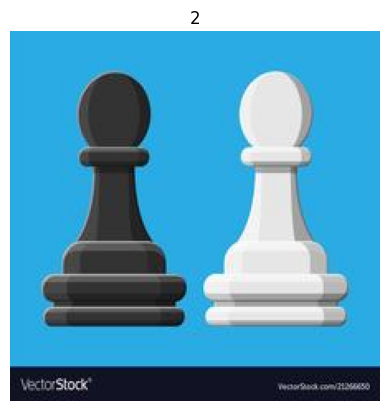

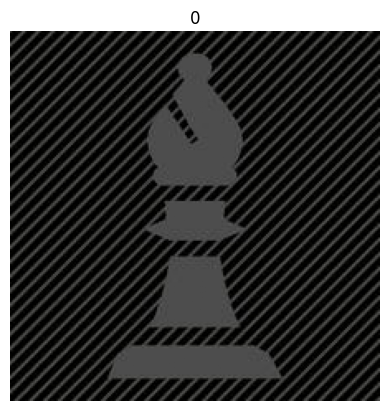

In [4]:
""" De que trata el dataset? """
# Viendo la carpeta de las imagenes, podemos observar que se tienen diferentes carpetas en las que se encuentran
# imagenes de diferentes piezas de ajegrez, como lo son alfil, caballo, peon, reina y torre.

""" Cuales son las clases? """
print(f"Clases: {dataset.classes}")

""" Cuantas imagenes hay por clase """
print(dataset.class_to_idx)
print(f"\nCantidad de imagenes: {len(dataset)}")
print(f"Cantidad de alfiles : {dataset.targets.count(0)}")
print(f"Cantidad de Caballos : {dataset.targets.count(1)}")
print(f"Cantidad de Peones : {dataset.targets.count(2)}")
print(f"Cantidad de Reinas : {dataset.targets.count(3)}")
print(f"Cantidad de Torre : {dataset.targets.count(4)}")

""" Cuál es el tamaño de las imágenes? """
print("\nYa que se redimensionaron las imagenes a 224x244 en transform, todas las imagenes tendrán ese tamaño")
img,_ = dataset[384]
print(img.shape)

""" Cuántas imágenes hay en total? """
print("\nTotal de imágenes:", len(dataset))
# Originalmente eran 651 imagenes, pero debimos eliminar una la cual su contenido era simplemente una imagen en negro, 
# lo cual podría perjudicar el aprendizaje del modelo

""" Grafique algunas imagenes de cada clase """
for i in indices:
    img,idx = dataset[i]
    plt.imshow(img.permute(1,2,0))
    plt.title(idx)
    plt.axis("off")
    plt.show()

En el siguiente bloque implemente el modelo que le permitirá clasificar las diferentes tipos de piezas en el ajedrez, justifique la arquitectura de la red.

In [5]:
import torch.nn as nn
import torch.nn.functional as F

class RedJaque(nn.Module):
    def __init__(self):
        super().__init__()
        #Para extraer los valores mas significativos de la imagen
        self.conv1 = nn.Conv2d(3,10,3,1,1)
        self.conv2 = nn.Conv2d(10,32,3,1,1)
        #Reducir la resolucion de la imagen
        self.pool = nn.MaxPool2d(2,2)

        #Aplanar para poder usar un vector aplanado
        self.fc1 = nn.Linear(32*56*56,64)
        #Capa para poder clasificar
        self.fc2 = nn.Linear(64,5)

    def forward(self, x):
        # Se aplican las funciones para trabajar con la imagen
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        #Aplanar los datos para usarlos en otra capa
        x = x.view(x.size(0), -1)             
        x = F.relu(self.fc1(x))               
        x = self.fc2(x)                       
        return x

En el siguiente bloque cree una instancia de su red neuronal convolucional definida anteriormente y defina una función de perdida y un optimizador.	

In [6]:
model = RedJaque()
criterion = nn.CrossEntropyLoss() #Para la clasificacion de las 5 clases
optimizer = torch.optim.Adam(model.parameters(),lr=0.001) #Optimizador que ajusta automaticamente el learning rate

En el siguiente bloque programe el entrenamiento de su red neuronal convolucional.

In [7]:
num_epoch = 30
running_loss = np.zeros(shape=(num_epoch, 2)) # Para almacenar las perdidas promedio en train y val
# loss_t = []
# loss_v = []
for i in range(num_epoch):
    train_loss, valid_loss = 0.0, 0.0 # Para calcular la perdida por época
    model.train()
    for img,index in train_loader:
        outputs = model(img) # Predicción
        loss = criterion(outputs,index)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item() 

    model.eval()
    for img,index in val_loader:
        with torch.no_grad(): # no cálculamos gradiente para validación
            outputs = model(img)
            loss = criterion(outputs,index)
            valid_loss += loss.item()

    # Calculamos la perdida promedio por epoca (ya que cada batch tiene su propia perdida)
    avg_train_loss = train_loss/len(train_loader.dataset)
    avg_valid_loss = valid_loss/len(val_loader.dataset)
    running_loss[i] = avg_train_loss, avg_valid_loss
    # loss_t.append(avg_train_loss)
    # loss_v.append(avg_valid_loss)

    print(f"Epoch [{i+1}/{num_epoch}], Train Loss: {avg_train_loss:.4f}, Valid Loss: {avg_valid_loss:.4f}")


Epoch [1/30], Train Loss: 0.0879, Valid Loss: 0.0568
Epoch [2/30], Train Loss: 0.0531, Valid Loss: 0.0506
Epoch [3/30], Train Loss: 0.0490, Valid Loss: 0.0494
Epoch [4/30], Train Loss: 0.0437, Valid Loss: 0.0485
Epoch [5/30], Train Loss: 0.0368, Valid Loss: 0.0467
Epoch [6/30], Train Loss: 0.0294, Valid Loss: 0.0442
Epoch [7/30], Train Loss: 0.0227, Valid Loss: 0.0438
Epoch [8/30], Train Loss: 0.0183, Valid Loss: 0.0455
Epoch [9/30], Train Loss: 0.0143, Valid Loss: 0.0641
Epoch [10/30], Train Loss: 0.0142, Valid Loss: 0.0555
Epoch [11/30], Train Loss: 0.0115, Valid Loss: 0.0630
Epoch [12/30], Train Loss: 0.0090, Valid Loss: 0.0634
Epoch [13/30], Train Loss: 0.0070, Valid Loss: 0.0607
Epoch [14/30], Train Loss: 0.0051, Valid Loss: 0.0995
Epoch [15/30], Train Loss: 0.0060, Valid Loss: 0.0677
Epoch [16/30], Train Loss: 0.0040, Valid Loss: 0.0695
Epoch [17/30], Train Loss: 0.0032, Valid Loss: 0.0822
Epoch [18/30], Train Loss: 0.0032, Valid Loss: 0.0829
Epoch [19/30], Train Loss: 0.0025, Va

En el siguiente bloque muestre el gráfico de entrenamiento y validación de su red neuronal convolucional.

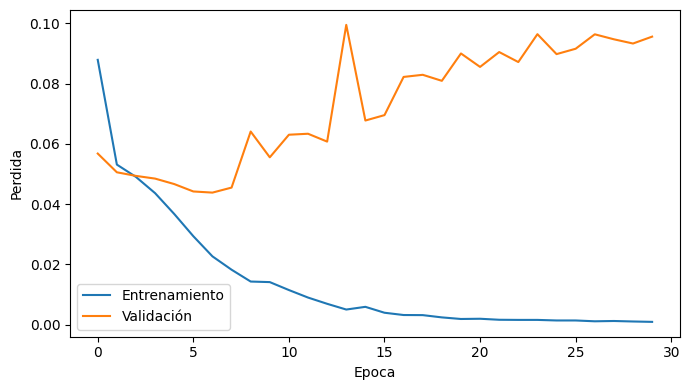

In [8]:
fig, ax = plt.subplots(figsize=(7, 4), tight_layout=True)
ax.plot(running_loss[:, 0], label='Entrenamiento')
ax.plot(running_loss[:, 1], label='Validación')
ax.set_xlabel('Epoca')
ax.set_ylabel('Perdida')
ax.legend()

Muestre diferentes métricas de evaluación de su red neuronal convolucional.

In [ ]:
from torchmetrics import Accuracy, Precision, Recall, F1Score



Concluya sobre las métricas obtenidas y el entrenamiento de su red neuronal convolucional.

En el siguiente bloque muestre las predicciones de su red neuronal convolucional y responda:
- ¿Cree que los errores son razonables?
- ¿Qué haría para mejorar la clasificación de las piezas de ajedrez?
